# Homework 7
## Mengxiang Jiang

The majority of the code here comes from the [Companion Jupyter notebooks for the book "Deep Learning with Python"](https://github.com/fchollet/deep-learning-with-python-notebooks) by François Chollet, specifically chapter 5 and 7.
If the code comes from somewhere else it will have a source linked to the original.\
[Video Link](https://youtu.be/EmG9-x8z_CA)

# IMBD Functional API Model

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
train_data = vectorize_sequences(train_data)
test_data = vectorize_sequences(test_data)

def build_model():
    inputs = keras.Input(shape=(10000,))
    features1 = layers.Dense(16, activation="relu")(inputs)
    features2 = layers.Dense(16, activation="relu")(features1)
    outputs = layers.Dense(1, activation="sigmoid")(features2)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

model_original = build_model()


2023-03-21 18:50:15.629111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 18:50:15.775497: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-21 18:50:19.709279: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 18:50:19.717526: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node 

### Using callbacks
#### EarlyStopping
**Using the `callbacks` argument in the `fit()` method**

In [2]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        restore_best_weights=True,
    )
]
history_original = model_original.fit(train_data, train_labels,
          epochs=100,
          callbacks=callbacks_list,
          batch_size=512, validation_split=0.4)

Epoch 1/100


2023-03-21 18:50:21.623203: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-21 18:50:21.634662: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fe41ad2fbb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-21 18:50:21.634674: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-03-21 18:50:21.646083: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-21 18:50:21.760911: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/30 [==============================] - 2s 23ms/step - loss: 0.5501 - accuracy: 0.7729 - val_loss: 0.4212 - val_accuracy: 0.8648
Epoch 2/100
30/30 [==============================] - 0s 9ms/step - loss: 0.3466 - accuracy: 0.8924 - val_loss: 0.3280 - val_accuracy: 0.8845
Epoch 3/100
30/30 [==============================] - 0s 9ms/step - loss: 0.2570 - accuracy: 0.9181 - val_loss: 0.2906 - val_accuracy: 0.8878
Epoch 4/100
30/30 [==============================] - 0s 10ms/step - loss: 0.2086 - accuracy: 0.9301 - val_loss: 0.2939 - val_accuracy: 0.8828
Epoch 5/100
30/30 [==============================] - 0s 9ms/step - loss: 0.1745 - accuracy: 0.9428 - val_loss: 0.2981 - val_accuracy: 0.8788
Epoch 6/100
30/30 [==============================] - 0s 9ms/step - loss: 0.1507 - accuracy: 0.9509 - val_loss: 0.2810 - val_accuracy: 0.8872
Epoch 7/100
30/30 [==============================] - 0s 9ms/step - loss: 0.1301 - accuracy: 0.9597 - val_loss: 0.2922 - val_accuracy: 0.8854
Epoch 8/100
30/30 [====

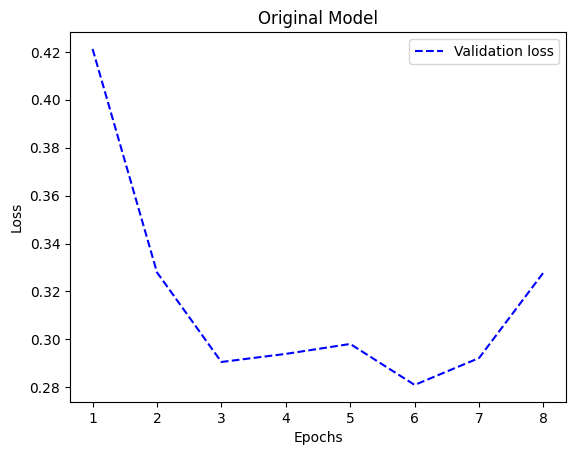

In [3]:
import matplotlib.pyplot as plt

val_loss = history_original.history["val_loss"]
epochs = range(1, len(val_loss)+1)
plt.plot(epochs, val_loss, "b--",
         label="Validation loss")
plt.title("Original Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

**Data Subset Function**

In [4]:
def create_data_subset(data, labels, size):
    """
    Create a random subset of data and labels with equal ratio of labels.

    Args:
    - data: A numpy array of training data
    - labels: A numpy array of training labels
    - size: The desired size of the subset

    Returns:
    - A tuple containing two numpy arrays: the subset of data and the subset of labels
    """
    # Count the number of data points in each class
    uniq_classes = np.unique(labels)
    num_classes = len(uniq_classes)
    num_points_per_class = int(size / num_classes)

    # Create a dictionary of list of indices for each class
    class_indices = {}
    for c in uniq_classes:
        class_indices[c] = np.where(labels == c)[0]

    # Select a random subset of indices from each class
    subset_indices = []
    for c in uniq_classes:
        subset_indices.extend(
            np.random.choice(
                class_indices[c], 
                size=num_points_per_class, 
                replace=False
            )
        )

    # Shuffle the subset indices and select the subset of data and labels
    np.random.shuffle(subset_indices)
    subset_data = data[subset_indices]
    subset_labels = labels[subset_indices]

    return subset_data, subset_labels

train_data_5k, train_labels_5k = create_data_subset(train_data, train_labels, 5000)
train_data_10k, train_labels_10k = create_data_subset(train_data, train_labels, 10000)
train_data_15k, train_labels_15k = create_data_subset(train_data, train_labels, 15000)
train_data_20k, train_labels_20k = create_data_subset(train_data, train_labels, 20000)

**Fitting Model On Subsets**

In [5]:
model_5k = build_model()
history_5k = model_5k.fit(train_data_5k, train_labels_5k,
                            epochs=100,
                            callbacks=callbacks_list,
                            batch_size=512, 
                            validation_split=0.4,
                            verbose=0)
model_10k = build_model()
history_10k = model_10k.fit(train_data_10k, train_labels_10k,
                            epochs=100,
                            callbacks=callbacks_list,
                            batch_size=512, 
                            validation_split=0.4,
                            verbose=0)
model_15k = build_model()
history_15k = model_15k.fit(train_data_15k, train_labels_15k,
                            epochs=100,
                            callbacks=callbacks_list,
                            batch_size=512, 
                            validation_split=0.4,
                            verbose=0)
model_20k = build_model()
history_20k = model_20k.fit(train_data_20k, train_labels_20k,
                            epochs=100,
                            callbacks=callbacks_list,
                            batch_size=512, 
                            validation_split=0.4,
                            verbose=0)

**Validation Loss Comparison**

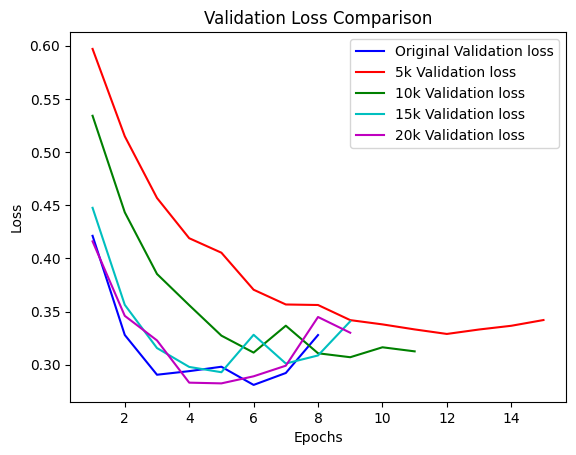

In [6]:
val_loss_original = history_original.history["val_loss"]
val_loss_5k = history_5k.history["val_loss"]
val_loss_10k = history_10k.history["val_loss"]
val_loss_15k = history_15k.history["val_loss"]
val_loss_20k = history_20k.history["val_loss"]
epochs_original = range(1, len(val_loss_original)+1)
epochs_5k = range(1, len(val_loss_5k)+1)
epochs_10k = range(1, len(val_loss_10k)+1)
epochs_15k = range(1, len(val_loss_15k)+1)
epochs_20k = range(1, len(val_loss_20k)+1)
plt.plot(epochs_original, val_loss_original, "b-",
         label="Original Validation loss")
plt.plot(epochs_5k, val_loss_5k, "r-",
         label="5k Validation loss")
plt.plot(epochs_10k, val_loss_10k, "g-",
         label="10k Validation loss")
plt.plot(epochs_15k, val_loss_15k, "c-",
         label="15k Validation loss")
plt.plot(epochs_20k, val_loss_20k, "m-",
         label="20k Validation loss")
plt.title("Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

**Validation Accuracy Comparison**

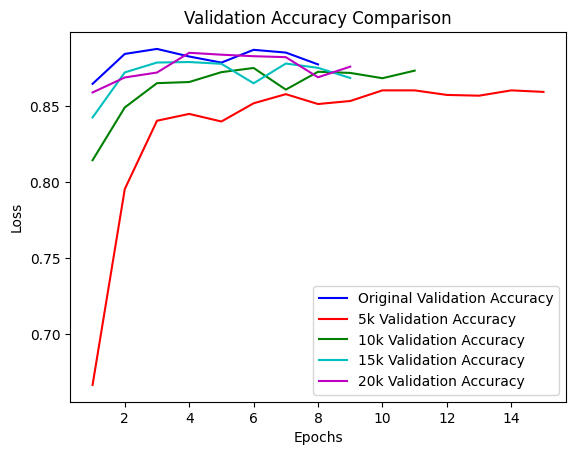

In [7]:
val_accuracy_original = history_original.history["val_accuracy"]
val_accuracy_5k = history_5k.history["val_accuracy"]
val_accuracy_10k = history_10k.history["val_accuracy"]
val_accuracy_15k = history_15k.history["val_accuracy"]
val_accuracy_20k = history_20k.history["val_accuracy"]
epochs_original = range(1, len(val_accuracy_original)+1)
epochs_5k = range(1, len(val_accuracy_5k)+1)
epochs_10k = range(1, len(val_accuracy_10k)+1)
epochs_15k = range(1, len(val_accuracy_15k)+1)
epochs_20k = range(1, len(val_accuracy_20k)+1)
plt.plot(epochs_original, val_accuracy_original, "b-",
         label="Original Validation Accuracy")
plt.plot(epochs_5k, val_accuracy_5k, "r-",
         label="5k Validation Accuracy")
plt.plot(epochs_10k, val_accuracy_10k, "g-",
         label="10k Validation Accuracy")
plt.plot(epochs_15k, val_accuracy_15k, "c-",
         label="15k Validation Accuracy")
plt.plot(epochs_20k, val_accuracy_20k, "m-",
         label="20k Validation Accuracy")
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

**Evaluating on Test Set**

In [8]:
metrics_original = model_original.evaluate(test_data, test_labels)
print(f"original test loss: {metrics_original[0]}, original test accuracy: {metrics_original[1]}")
metrics_5k = model_5k.evaluate(test_data, test_labels)
print(f"5k test loss: {metrics_5k[0]}, 5k test accuracy: {metrics_5k[1]}")
metrics_10k = model_10k.evaluate(test_data, test_labels)
print(f"10k test loss: {metrics_10k[0]}, 10k test accuracy: {metrics_10k[1]}")
metrics_15k = model_15k.evaluate(test_data, test_labels)
print(f"15k test loss: {metrics_15k[0]}, 15k test accuracy: {metrics_15k[1]}")
metrics_20k = model_20k.evaluate(test_data, test_labels)
print(f"20k test loss: {metrics_20k[0]}, 20k test accuracy: {metrics_20k[1]}")

782/782 [==============================] - 1s 1ms/step - loss: 0.3036 - accuracy: 0.8822
original test loss: 0.3035990297794342, original test accuracy: 0.8821600079536438
782/782 [==============================] - 1s 1ms/step - loss: 0.3497 - accuracy: 0.8545
5k test loss: 0.3497326672077179, 5k test accuracy: 0.8544800281524658
782/782 [==============================] - 1s 1ms/step - loss: 0.3238 - accuracy: 0.8731
10k test loss: 0.3237822353839874, 10k test accuracy: 0.8730800151824951
782/782 [==============================] - 1s 1ms/step - loss: 0.3089 - accuracy: 0.8774
15k test loss: 0.30888795852661133, 15k test accuracy: 0.8773599863052368
782/782 [==============================] - 1s 1ms/step - loss: 0.2981 - accuracy: 0.8801
20k test loss: 0.2980813682079315, 20k test accuracy: 0.880079984664917
